In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pybaseball import statcast
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Make plots look nicer
sns.set(style="whitegrid", context="talk")


In [2]:
# Pull Statcast data for a random week
df = statcast(start_dt="2025-05-01", end_dt="2025-05-07")
print(df.shape)
df.head()


This is a large query, it may take a moment to complete


  0%|                                        | 0/7 [00:00<?, ?it/s]/Users/calebgoodman/Documents/coding/funProjects/bball/venv/lib/python3.13/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
/Users/calebgoodman/Documents/coding/funProjects/bball/venv/lib/python3.13/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
 14%|████▌                           | 1/7 [00:00<00:04,  1.21it/s]/Users/calebgoodman/Documents/coding/funProjects/bball/venv/lib/python3.13/s

(27640, 118)


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
2167,FC,2025-05-07,86.9,-1.96,5.41,"Pagán, Emilio",592696,641941,strikeout,swinging_strike,...,<NA>,2.35,-0.33,0.33,38.2,19.318001,-12.604511,28.102435,44.832212,35.25063
2185,FF,2025-05-07,95.6,-1.81,5.58,"Pagán, Emilio",592696,641941,NaN,foul,...,<NA>,0.96,0.88,-0.88,40.0,11.656366,-13.122157,22.828719,42.578184,30.960237
2261,FS,2025-05-07,83.2,-2.01,5.39,"Pagán, Emilio",592696,641941,NaN,blocked_ball,...,<NA>,3.26,0.95,-0.95,37.9,<NA>,<NA>,<NA>,<NA>,<NA>
2297,FC,2025-05-07,87.3,-1.92,5.49,"Pagán, Emilio",592696,641941,NaN,swinging_strike,...,<NA>,2.38,-0.16,0.16,41.6,5.126281,23.36121,27.126195,51.431286,13.633519
2362,FC,2025-05-07,89.1,-1.95,5.52,"Pagán, Emilio",592696,641941,NaN,swinging_strike,...,<NA>,2.21,-0.24,0.24,40.9,29.90112,-38.316029,35.06171,36.566067,54.539916


In [3]:
# Columns needed for xwOBA model
cols = ["game_date", "player_name", "events", "launch_speed", "launch_angle", 
        "BB", "IBB", "HBP", "1B", "2B", "3B", "HR", "AB", "woba_value"]

for c in cols:
    if c not in df.columns:
        df[c] = 0  # fill missing columns if needed

df_model = df[cols].dropna(subset=["launch_speed", "launch_angle", "woba_value"])
df_model.head()


,game_date,player_name,events,launch_speed,launch_angle,BB,IBB,HBP,1B,2B,3B,HR,AB,woba_value
2426,2025-05-07,"Pagán, Emilio",single,108.2,6,0,0,0,0,0,0,0,0,0.9
2587,2025-05-07,"Pagán, Emilio",field_out,85.8,39,0,0,0,0,0,0,0,0,0.0
3347,2025-05-07,"De Los Santos, Enyel",field_out,102.2,15,0,0,0,0,0,0,0,0,0.0
2112,2025-05-07,"Santillan, Tony",field_out,84.5,48,0,0,0,0,0,0,0,0,0.0
3466,2025-05-07,"Santillan, Tony",field_out,84.2,45,0,0,0,0,0,0,0,0,0.0


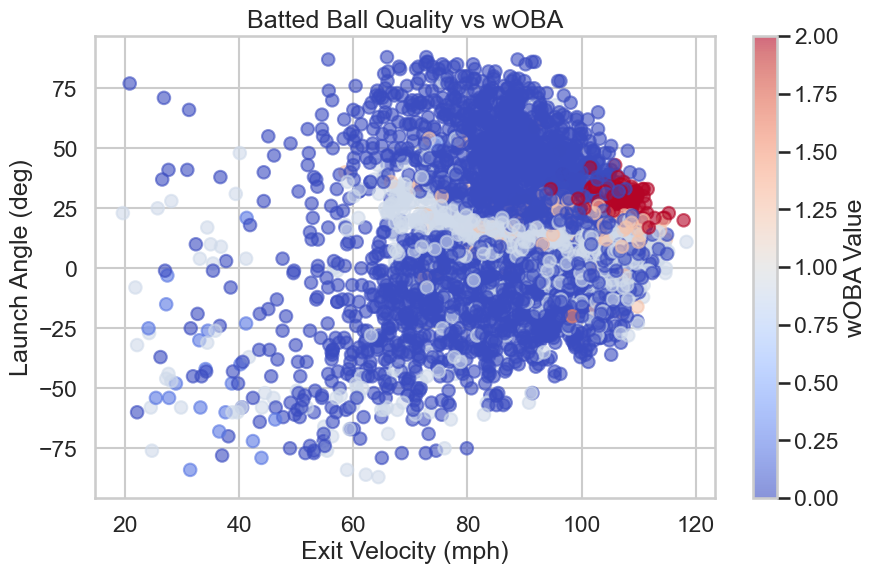

In [4]:
plt.figure(figsize=(10,6))
sc = plt.scatter(df_model["launch_speed"], df_model["launch_angle"], 
                 c=df_model["woba_value"], cmap="coolwarm", alpha=0.6)
plt.colorbar(sc, label="wOBA Value")
plt.xlabel("Exit Velocity (mph)")
plt.ylabel("Launch Angle (deg)")
plt.title("Batted Ball Quality vs wOBA")
plt.show()


In [5]:
# Optional: use sprint speed only for weak balls (EV < 50, LA < 0)
if "sprint_speed" not in df_model.columns:
    df_model["sprint_speed"] = 0  # placeholder if missing

df_model["use_sprint_speed"] = ((df_model["launch_speed"] < 50) & (df_model["launch_angle"] < 0)).astype(int)
df_model["sprint_speed_feature"] = df_model["sprint_speed"] * df_model["use_sprint_speed"]


In [6]:
X = df_model[["launch_speed", "launch_angle", "sprint_speed_feature"]]
y = df_model["woba_value"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [7]:
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

,n_estimators,500
,criterion,'squared_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Random Forest MSE: 0.20375488002179423
Random Forest R²: 0.35760584077883284


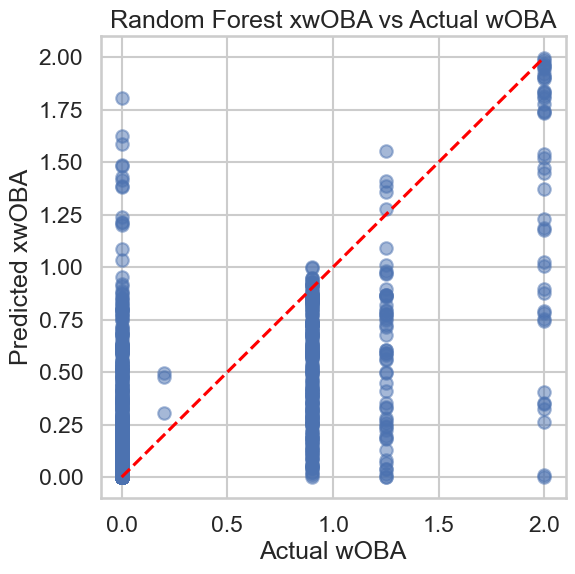

In [8]:
y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Random Forest MSE:", mse)
print("Random Forest R²:", r2)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual wOBA")
plt.ylabel("Predicted xwOBA")
plt.plot([0, 2], [0, 2], color="red", linestyle="--")
plt.title("Random Forest xwOBA vs Actual wOBA")
plt.show()


launch_speed            0.536138
launch_angle            0.463862
sprint_speed_feature    0.000000
dtype: float64


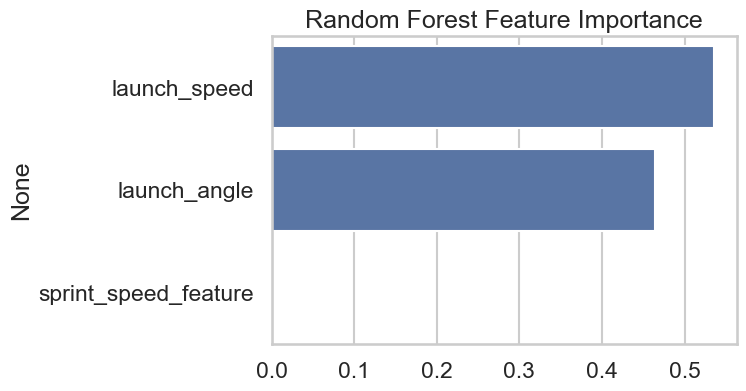

In [9]:
importances = rf_model.feature_importances_
feature_names = X.columns

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print(feat_imp)

plt.figure(figsize=(6,4))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Random Forest Feature Importance")
plt.show()
